In [3]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [4]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [5]:
%load_ext autoreload
%autoreload 2
import copy
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from learning_wavelets.data.datasets import im_dataset_bsd68
from learning_wavelets.models.learned_wavelet import learnlet
from learning_wavelets.utils.metrics import metrics_from_ds, metrics_original_from_ds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
np.random.seed(0)

In [7]:
dynamic_denoising_net_params = [
    {
        'name': 'learnlet_0_55_big_bsd',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_st_bsd500_0_55_1580806694',
        'epoch': 500,
    },
]

In [8]:
noise_stds = [5, 15, 20, 25, 30, 50, 75]

In [9]:
noise_std_metrics = {}
n_samples = None
for noise_std in tqdm_notebook(noise_stds, 'Noise stds'):
    metrics = []
    im_ds = im_dataset_bsd68(
        mode='testing', 
        batch_size=1, 
        patch_size=None, 
        noise_std=noise_std, 
        return_noise_level=False,
        n_pooling=5,
        n_samples=n_samples,
    )
    metrics.append(('original', metrics_original_from_ds(im_ds)))
        
    for net_params in dynamic_denoising_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=True,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=True,
            n_pooling=5,
            n_samples=n_samples,
            set_noise_zero=True,
        )
        metrics.append((net_params['name']+'_no_thresh', metrics_from_ds(im_ds, **net_params)))

#     metrics.append(('bm3d', metrics_bm3d(im_gen_test)))
#     metrics.append(('wavelets_24', metrics_wavelets(im_gen_test, '24', noise_std=noise_std)))
#     metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())
    noise_std_metrics[noise_std] = metrics

/volatile/home/Zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=1)
/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:43: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt, pred, multichannel=True, data_range=1


In [10]:
noise_std_metrics

{5: [('original', PSNR = 34.15 +/- 0.02959 SSIM = 0.8855 +/- 0.1022),
  ('learnlet_0_55_big_bsd', PSNR = 36.38 +/- 4.085 SSIM = 0.9569 +/- 0.03071),
  ('learnlet_0_55_big_bsd_no_thresh',
   PSNR = 33.81 +/- 0.96 SSIM = 0.8905 +/- 0.09317)],
 15: [('original', PSNR = 24.61 +/- 0.02602 SSIM = 0.5691 +/- 0.2586),
  ('learnlet_0_55_big_bsd', PSNR = 30.84 +/- 4.749 SSIM = 0.8589 +/- 0.09629),
  ('learnlet_0_55_big_bsd_no_thresh',
   PSNR = 24.92 +/- 0.5862 SSIM = 0.5881 +/- 0.249)],
 20: [('original', PSNR = 22.11 +/- 0.02707 SSIM = 0.4662 +/- 0.266),
  ('learnlet_0_55_big_bsd', PSNR = 29.48 +/- 4.847 SSIM = 0.815 +/- 0.1113),
  ('learnlet_0_55_big_bsd_no_thresh',
   PSNR = 22.51 +/- 0.6657 SSIM = 0.4864 +/- 0.2614)],
 25: [('original', PSNR = 20.17 +/- 0.03333 SSIM = 0.3883 +/- 0.2565),
  ('learnlet_0_55_big_bsd', PSNR = 28.47 +/- 4.902 SSIM = 0.7761 +/- 0.1187),
  ('learnlet_0_55_big_bsd_no_thresh',
   PSNR = 20.65 +/- 0.7121 SSIM = 0.409 +/- 0.256)],
 30: [('original', PSNR = 18.59 +/- 0

In [11]:
# PSNR table
psnr_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in dynamic_denoising_net_params] + [p['name']+'_no_thresh' for p in dynamic_denoising_net_params],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    psnr_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        psnr_metrics_table.loc[i, name] = "{mean:.4} ({std:.2})".format(
            mean=m.metrics['PSNR'].mean(), 
            std=m.metrics['PSNR'].stddev(),
        )
psnr_metrics_table

,noise_std,learnlet_0_55_big_bsd,learnlet_0_55_big_bsd_no_thresh,original
0,5,36.38 (2.0),33.81 (0.48),34.15 (0.015)
1,15,30.84 (2.4),24.92 (0.29),24.61 (0.013)
2,20,29.48 (2.4),22.51 (0.33),22.11 (0.014)
3,25,28.47 (2.5),20.65 (0.36),20.17 (0.017)
4,30,27.66 (2.5),19.14 (0.38),18.59 (0.015)
5,50,25.48 (2.4),15.08 (0.4),14.15 (0.016)
6,75,23.77 (2.2),12.19 (0.34),10.63 (0.017)


In [14]:
# SSIM table
ssim_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in dynamic_denoising_net_params] + [p['name']+'_no_thresh' for p in dynamic_denoising_net_params])
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    ssim_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        ssim_metrics_table.loc[i, name] = "{mean:.4} ({std:.4})".format(
            mean=m.metrics['SSIM'].mean(), 
            std=m.metrics['SSIM'].stddev(),
        )
ssim_metrics_table

,noise_std,learnlet_0_55_big_bsd,learnlet_0_55_big_bsd_no_thresh,original
0,5,0.9569 (0.01535),0.8905 (0.04658),0.8855 (0.05112)
1,15,0.8589 (0.04814),0.5881 (0.1245),0.5691 (0.1293)
2,20,0.815 (0.05567),0.4864 (0.1307),0.4662 (0.133)
3,25,0.7761 (0.05934),0.409 (0.128),0.3883 (0.1282)
4,30,0.7395 (0.06297),0.3488 (0.1217),0.328 (0.1198)
5,50,0.6192 (0.06708),0.2039 (0.09002),0.1831 (0.08324)
6,75,0.5064 (0.06344),0.1204 (0.05911),0.1014 (0.05182)


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
sns.set(style="whitegrid", palette="muted", rc={'figure.figsize': (9, 5), 'image.cmap': 'gray'})

In [22]:
relative_to_original = True

model_family_str = r'$\bf{Model}$'
train_stds_str = r'$\bf{Train}$  $\bf{std}$'
noise_std_str = 'Test noise standard deviation'
psnr_str = 'Ratio over original PSNR'
# PSNR to plot
psnr_to_plot = pd.DataFrame(
    columns=[noise_std_str, psnr_str, 'psnr-std-dev', 'model_name', model_family_str, train_stds_str]
)

def from_name_to_family(model_name):
    if 'learnlet' in model_name:
        if 'no_thresh' in model_name:
            return 'Learnlets \n w/o thresholding'
        else:
            return 'Learnlets'
    elif 'unet' in model_name:
        return 'U-net'
    elif 'bm3d' in model_name:
        return 'BM3D'
    elif 'wavelets' in model_name:
        return 'Wavelets'
    else:
        return 'Original'
    
def from_name_to_train_stds(model_name):
    if '30' in model_name:
        return '30'
    elif '20_40' in model_name:
        return '[20; 40]'
    else:
        return '[0; 55]'

family_model_to_color = {
    'U-net': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
    'Learnlets': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
    'Learnlets \n w/o thresholding': (0.8333333333333333, 0.5215686274509804, 0.3901960784313726),
    'BM3D': 'violet',
    'Wavelets': 'red',
    'Original': (0.41568627450980394, 0.8, 0.39215686274509803),
}
index = 0
orig_psnrs = {}
for i_noise, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    for j_model, (name, m) in enumerate(metrics):
        if relative_to_original and name == 'original':
            orig_psnrs[noise_std] = m.metrics['PSNR'].mean()
        else:
            psnr_to_plot.loc[index, noise_std_str] = noise_std
            psnr_to_plot.loc[index, psnr_str] = m.metrics['PSNR'].mean()
            psnr_to_plot.loc[index, 'psnr-std-dev'] = m.metrics['PSNR'].stddev() / 2
            psnr_to_plot.loc[index, 'model_name'] = name
            psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
            psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
            index += 1
    

if relative_to_original:
    for noise_std, orig_psnr in orig_psnrs.items():
        psnr_to_plot.loc[psnr_to_plot[noise_std_str] == noise_std, psnr_str] = psnr_to_plot[psnr_to_plot[noise_std_str] == noise_std][psnr_str] / orig_psnr
    
psnr_to_plot

,Test noise standard deviation,Ratio over original PSNR,psnr-std-dev,model_name,$\bf{Model}$,$\bf{Train}$ $\bf{std}$
0,5,1.06525,1.02117,learnlet_0_55_big_bsd,Learnlets,[0; 55]
1,5,0.99005,0.23999,learnlet_0_55_big_bsd_no_thresh,Learnlets \n w/o thresholding,[0; 55]
2,15,1.25301,1.18722,learnlet_0_55_big_bsd,Learnlets,[0; 55]
3,15,1.01242,0.146554,learnlet_0_55_big_bsd_no_thresh,Learnlets \n w/o thresholding,[0; 55]
4,20,1.33311,1.21179,learnlet_0_55_big_bsd,Learnlets,[0; 55]
5,20,1.01785,0.166424,learnlet_0_55_big_bsd_no_thresh,Learnlets \n w/o thresholding,[0; 55]
6,25,1.41107,1.22552,learnlet_0_55_big_bsd,Learnlets,[0; 55]
7,25,1.0234,0.178037,learnlet_0_55_big_bsd_no_thresh,Learnlets \n w/o thresholding,[0; 55]
8,30,1.48773,1.22811,learnlet_0_55_big_bsd,Learnlets,[0; 55]
9,30,1.02966,0.190486,learnlet_0_55_big_bsd_no_thresh,Learnlets \n w/o thresholding,[0; 55]


In [23]:
# plt.figure()
# psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
# lplot = sns.lineplot(
#     x=noise_std_str, 
#     y=psnr_str, 
#     hue=model_family_str,
#     style=train_stds_str,
#     data=psnr_to_plot,
#     palette=family_model_to_color,
# )
# lplot.errorbar(
#     x=noise_std_str, 
#     y=psnr_str,
#     yerr='psnr-std-dev',
#     fmt='none',
#     ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
#     data=psnr_to_plot,
#     alpha=0.3,
#     label=None,
# )
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
# plt.subplots_adjust(right=0.83)
# plt.savefig(f'gen.png')

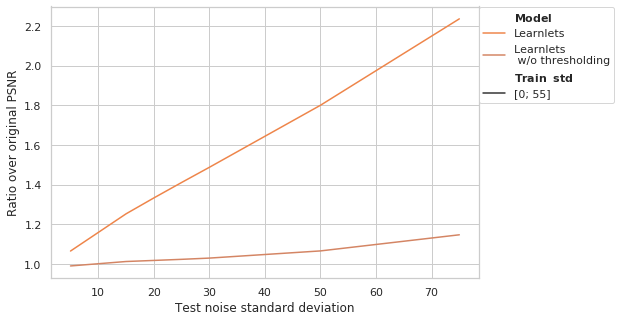

In [27]:
plt.figure()
psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
lplot = sns.lineplot(
    x=noise_std_str, 
    y=psnr_str, 
    hue=model_family_str,
    style=train_stds_str,
    data=psnr_to_plot,
    palette=family_model_to_color,
)
# lplot.errorbar(
#     x=noise_std_str, 
#     y=psnr_str,
#     yerr='psnr-std-dev',
#     fmt='none',
#     ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
#     data=psnr_to_plot,
#     alpha=0.3,
#     label=None,
# )
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
plt.subplots_adjust(right=0.785)
plt.savefig(f'gen_wo_error_bars.png')